**Case: Optimering af Online Retail Platform**

Du arbejder som en dataingeniør i en online detailhandelsvirksomhed ved navn "X," der ønsker at forbedre sin kundeservice og salgsstrategi ved at udnytte Big Data. Virksomheden har adgang til en bred vifte af datakilder, herunder transaktionsdata, brugeradfærd på webstedet, sociale mediedata og eksterne markedsdata. Din opgave er at designe og opbygge en mindre Big Data løsning for X.


1. **Dataindsamling og Opsamling:**
   - Design en løsning til at indsamle og opsamle data fra forskellige kilder i realtid, inklusive transaktionsdata, webadfærd og sociale mediedata. Overvej anvendelse af HTTPS (REST), Kafka eller MQTT til dataindsamling.
   - Sikkerhedsaspekter er vigtige. Implementer kryptering af data under transport for at beskytte følsomme oplysninger.

In [1]:
#insert storageDrive.csv to Microsoft Sql Server database

import csv
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import urllib

df = pd.read_csv('walmart.csv')
#Print available drivers
#print(pyodbc.drivers())

import urllib

params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=tcp:nextchsolutions.database.windows.net,1433;DATABASE=NexTechSolutions;UID=ktfs;PWD=Password1!;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=60;")
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params,fast_executemany=True)

In [3]:
#Put the 'raw data' into a SQL database
df.to_sql('WalmartDb', engine, if_exists='append', index=False)

-1

2. **Dataforberedelse og Transformation:**
   - Opbyg en pipeline til at rengøre, strukturere og forberede data til analyse. Dette inkluderer valg af filformater som CSV, XML, HDF5 osv.
   - Håndter forskellige datatyper, herunder struktureret og ustruktureret data.

In [4]:
import luigi
import pyodbc
import pandas as pd
import csv
from sqlalchemy import create_engine, types
import os
import urllib

params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=tcp:nextchsolutions.database.windows.net,1433;DATABASE=NexTechSolutions;UID=ktfs;PWD=Password1!;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=60;")
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params,fast_executemany=True)
#engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

class ExtractDataTask(luigi.Task):
    #The task to run
    def run(self):
        # Check if the file exists and delete it if it does
        if os.path.exists('walmart_extracted.csv'):
            os.remove('walmart_extracted.csv')
        
        conn_str = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=tcp:nextchsolutions.database.windows.net,1433;DATABASE=NexTechSolutions;UID=ktfs;PWD=Password1!;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=60;'
        conn = pyodbc.connect(conn_str)
        query = '''
            SELECT * FROM WalmartDb
        '''
        df = pd.read_sql(query, conn)
        df.to_csv('walmart_extracted.csv', index=False)
        conn.close()
    #The output of the task
    def output(self):
        return luigi.LocalTarget('walmart_extracted.csv')


class TransformDataTask(luigi.Task):
    #The task this task is dependent on, the task will not run unless the task defined in requires() has completed successfully.
    def requires(self):
        return ExtractDataTask()

    def run(self):
        # Check if the file exists and delete it if it does
        if os.path.exists('walmart_transformed.csv'):
            os.remove('walmart_transformed.csv')

        input_file = self.input().path
        df = pd.read_csv(input_file)
        df = df.drop_duplicates()
        df = df.dropna()
        df.to_csv('walmart_transformed.csv', index=False)

    def output(self):
        return luigi.LocalTarget('walmart_transformed.csv')


class LoadDataTask(luigi.Task):
    def requires(self):
        return TransformDataTask()

    def run(self):
        input_file = self.input().path
        df = pd.read_csv(input_file)

        column_types = {col: sql_type for col, sql_type in zip(df.columns, df.dtypes)}

        column_types['Store'] = types.BigInteger()
        column_types['Date'] = types.String()
        column_types['Weekly_Sales'] = types.FLOAT()
        column_types['Holiday_Flag'] = types.BigInteger()
        column_types['Temperature'] = types.Float()
        column_types['Fuel_Price'] = types.Float()
        column_types['CPI'] = types.Float()
        column_types['Unemployment'] = types.Float()
        df.to_sql('WalmartDb_clean', engine, if_exists='replace', index=False,dtype=column_types)

# Run the pipeline
luigi.build([LoadDataTask()], local_scheduler=True)


DEBUG: Checking if LoadDataTask() is complete
c:\Users\ssc\AppData\Local\Programs\Python\Python310\lib\site-packages\luigi\worker.py:419: UserWarning: Task LoadDataTask() without outputs has no custom complete() method
  is_complete = task.complete()
DEBUG: Checking if TransformDataTask() is complete
INFO: Informed scheduler that task   LoadDataTask__99914b932b   has status   PENDING
INFO: Informed scheduler that task   TransformDataTask__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 19880] Worker Worker(salt=8755329372, workers=1, host=UIT-MJ2rtjbJ8yG, username=ssc, pid=19880) running   LoadDataTask()


INFO: [pid 19880] Worker Worker(salt=8755329372, workers=1, host=UIT-MJ2rtjbJ8yG, username=ssc, pid=19880) done      LoadDataTask()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LoadDataTask__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=8755329372, workers=1, host=UIT-MJ2rtjbJ8yG, username=ssc, pid=19880) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 1 complete ones were encountered:
    - 1 TransformDataTask()
* 1 ran successfully:
    - 1 LoadDataTask()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

3. **Analyse og Præsentation:**
   - Anvend dataanalyseværktøjer og teknikker til at trække indsigt fra de forberedte data.
   - Design dashboards eller rapporter for at give virksomhedens beslutningstagere nem adgang til relevante oplysninger.

C:\Users\ssc\AppData\Local\Temp\ipykernel_20972\2832748008.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

c:\Users\ssc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\ssc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\ssc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\ssc\AppD

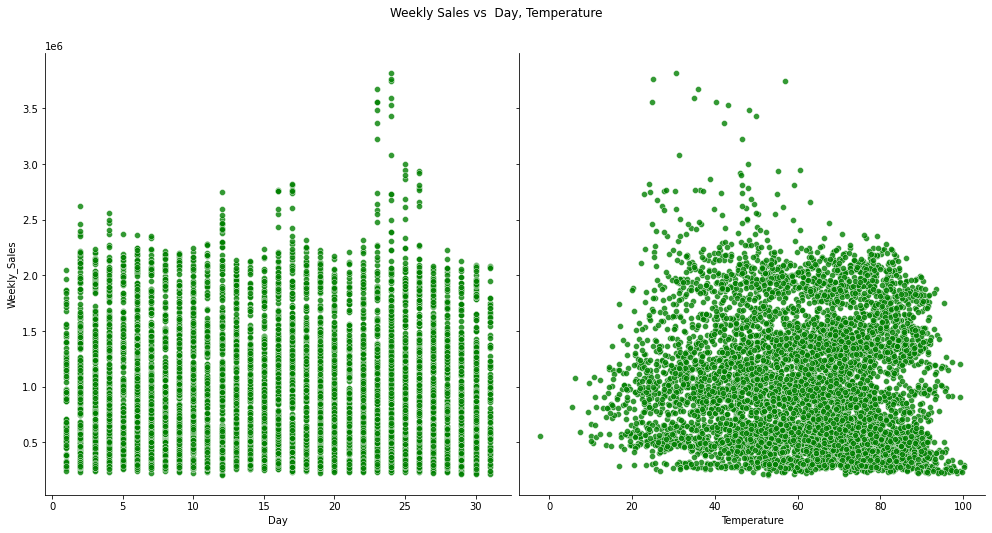

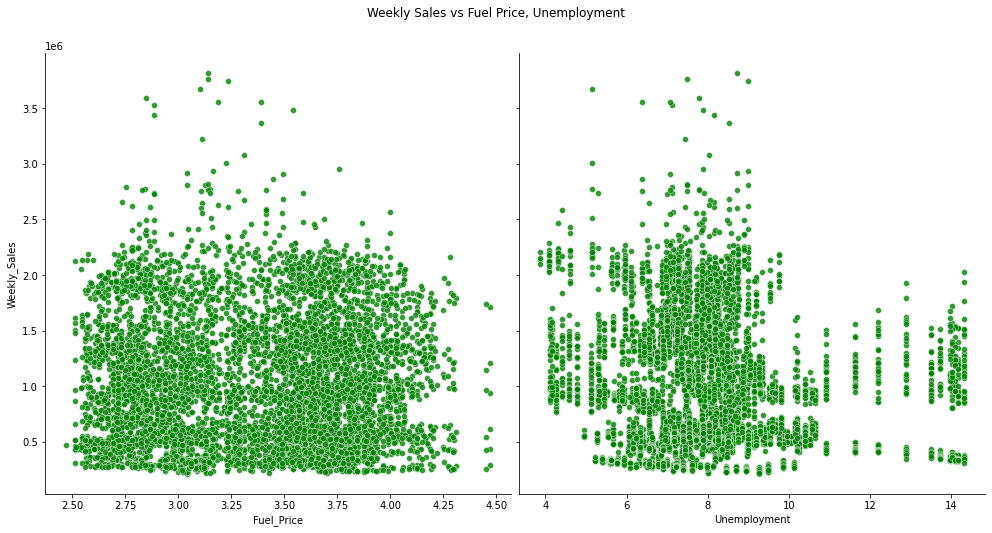

In [8]:

import seaborn as sns
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import dash
import dash_html_components as html
from PIL import Image


conn_str = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=tcp:nextchsolutions.database.windows.net,1433;DATABASE=NexTechSolutions;UID=ktfs;PWD=Password1!;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=60;'
conn = pyodbc.connect(conn_str)
query = '''
    SELECT * FROM WalmartDb_clean
'''
df = pd.read_sql(query, conn)

df['Date'] = pd.to_datetime(df['Date'],format='mixed')

df['Day'] = df['Date'].dt.day

g = sns.pairplot(data=df,x_vars=['Day','Temperature'],y_vars='Weekly_Sales',kind='scatter', plot_kws={'alpha':0.8, 'color': 'green'}, height=7)
g.fig.suptitle('Weekly Sales vs  Day, Temperature', y=1.05)
g.fig.savefig('pairplot.png')
g = sns.pairplot(data=df,x_vars=['Fuel_Price','Unemployment'],y_vars='Weekly_Sales',kind='scatter', plot_kws={'alpha':0.8, 'color': 'green'}, height=7)
g.fig.suptitle('Weekly Sales vs Fuel Price, Unemployment', y=1.05)
g.fig.savefig('pairplot1.png')

pil_image = Image.open("pairplot.png")
pil_image1 = Image.open("pairplot1.png")

app = dash.Dash(__name__)
app.title = 'Dash Board'
app.layout = html.Div(
    children=[
        
        html.H1('DASH BOARD', style={'textAlign': 'center'}),
        html.Div(children=[
            html.Img(src=pil_image, alt='pairplot'),
            html.Img(src=pil_image1, alt='pairplot')
        ], style={'textAlign': 'center'})

])
if __name__ == '__main__':
    app.run(debug=False)

4. **Sikkerhed og Overholdelse:**
   - Implementer omfattende sikkerhedsforanstaltninger for at beskytte data mod uautoriseret adgang og misbrug.
   - Overhold databeskyttelsesregler, især GDPR, når du håndterer brugerdata.

Vores database server hoster vi ved Azure, og derinde kan man bestemme hvilke IP-adresser som har adgang til serveren.
Så der har vi opsat det, så det kun er en IP-adresse som har adgang til den.
Og for at få adgang til SQL-serveren, skal man også angive brugernavn og kode.
De står i plain text flere steder i koden, men eftersom at den tjekker hvilken ip-adresse som laver kaldet, ville der ikke være et problem.


I forhold til GDPR har vi ikke noget følsomt data, så der har vi ikke gjort noget specielt.

5. **Skalering og Optimering:**
   - Overvej hvordan løsningen kan skaleres i fremtiden med virksomhedens vækst og øgede datamængder.
   - Identificer muligheder for ydeevneoptimering.

Din Big Data løsning skal hjælpe RetailX med at træffe informerede beslutninger, forbedre kundeservicen og optimere salgsstrategien ved at udnytte de enorme datamængder, der er tilgængelige. Din evne til at integrere dataindsamling, forberedelse, analyse og sikkerhed vil være afgørende for succes i denne opgave.